In [34]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import torch

In [42]:
INPUT_SIZE = 3 # thickness, height, angle
LATENT_DIM = 3
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # 
NUM_EPOCHS = 100

TEST_SIZE = 0.15
RANDOM_STATE = 42
device = "cpu"

In [43]:
df = pd.read_csv(r'../MLP/processed_bending_stiffness.csv')

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
if removed_count > 0:
    print(f"Removed {removed_count} duplicate row(s) from the dataset.")
print(f"Shape of dataset after removing duplicates: {df.shape}")

stats_to_get = ['min', 'max', 'mean', 'median', 'std', 'skew']

detailed_stats = df[['Thickness', 'Height', 'Angle (deg)', 'Bending_Stiffness']].agg(stats_to_get)

print("\nDetailed Feature Statistics:")
print(detailed_stats.round(4))

correlations = df.corr()['Bending_Stiffness'].sort_values(ascending=False)
print("\nCorrelation with Bending_Stiffness:")
print(correlations)

X = df[['Thickness', 'Height', 'Angle (deg)']]
y = df['Bending_Stiffness']

X_temp, X_test, y_temp, y_test = train_test_split(
    X.values, 
    y.values, 
    test_size=TEST_SIZE,  # 0.2 = 20% for test
    random_state=RANDOM_STATE
)

# Second split: split remaining data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total (so 60% train, 20% val, 20% test)
    random_state=RANDOM_STATE
)

print(f"Train set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

DATASET_SIZE = len(df)

Removed 685 duplicate row(s) from the dataset.
Shape of dataset after removing duplicates: (891, 4)

Detailed Feature Statistics:
        Thickness    Height  Angle (deg)  Bending_Stiffness
min        3.1790   12.7710       9.1000             9.8995
max        9.5230  126.9710      70.0000         29190.2693
mean       6.2740   70.7137      55.2193          7014.2756
median     6.1740   69.4900      59.8000          5379.0662
std        1.8369   32.8518      13.2910          6392.2232
skew       0.1189    0.0020      -1.2053             1.1334

Correlation with Bending_Stiffness:
Bending_Stiffness    1.000000
Height               0.851361
Angle (deg)          0.554264
Thickness            0.373695
Name: Bending_Stiffness, dtype: float64
Train set size: 567 (63.6%)
Validation set size: 190 (21.3%)
Test set size: 134 (15.0%)


In [44]:
# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Create DataLoaders
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)
validation_dataset = TensorDataset(X_val_tensor, y_val_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [45]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=3, condition_dim=1, hidden_dim=64, latent_dim=LATENT_DIM, device=device):
        super(ConditionalVAE, self).__init__()

        # encoder - LARGER
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.LeakyReLU()
        )
        
        # latent space
        self.mean_layer = nn.Linear(hidden_dim//2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim//2, latent_dim)

        # decoder - LARGER
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim//2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
     
    def encode(self, x, condition):
        x_with_condition = torch.cat([x, condition], dim=1)
        x = self.encoder(x_with_condition)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std).to(device)      
        z = mean + std * epsilon
        return z

    def decode(self, z, condition):
        # Concatenate latent with condition
        z = torch.cat([z, condition], dim=1)
        return self.decoder(z)

    def forward(self, x, condition):
        mean, logvar = self.encode(x, condition)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z, condition)
        return x_hat, mean, logvar

def loss_function(forward_model, x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [46]:
model = ConditionalVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

forward_model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    
    nn.Linear(16, 1)
).to(device)

forward_model.load_state_dict(
    torch.load(
        r"C:\Users\mason\Work\CMEC_SandwichPanel\Models\MLP\Parameters_To_Stiffness\model_weight.pth",
        map_location=device
    )
)
forward_model.eval()

C:\Users\mason\AppData\Local\Temp\ipykernel_388\2091407131.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=16, out_features=1, bias=True)
)


First batch diagnostics:
Input shape: torch.Size([32, 3]), Condition shape: torch.Size([32, 1])
First sample input (normalized): [-1.4854727   1.5297809   0.49792537]
First sample condition (normalized stiffness): 0.3554
First sample output: [ 0.18719614  0.02658875 -0.07000814]
	Epoch   1 | Train - Total:   2.8012 | Val - Total:   2.6671
	Epoch   2 | Train - Total:   2.2468 | Val - Total:   2.0286
	Epoch   3 | Train - Total:   1.8962 | Val - Total:   1.8794
	Epoch   4 | Train - Total:   1.7771 | Val - Total:   1.7767
	Epoch   5 | Train - Total:   1.7269 | Val - Total:   1.7217
	Epoch   6 | Train - Total:   1.6696 | Val - Total:   1.7071
	Epoch   7 | Train - Total:   1.6544 | Val - Total:   1.6152
	Epoch   8 | Train - Total:   1.5901 | Val - Total:   1.6731
	Epoch   9 | Train - Total:   1.6231 | Val - Total:   1.6294
	Epoch  10 | Train - Total:   1.5182 | Val - Total:   1.6389
	Epoch  11 | Train - Total:   1.5442 | Val - Total:   1.5658
	Epoch  12 | Train - Total:   1.5199 | Val - Tot

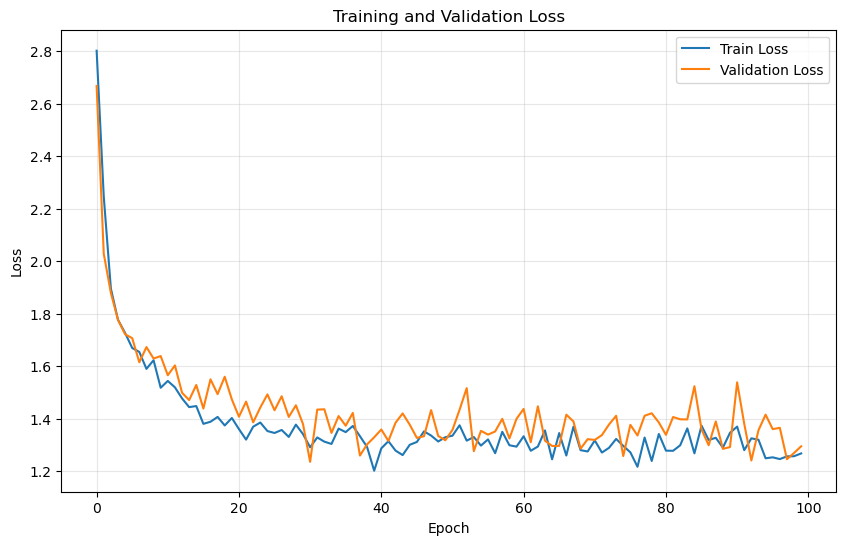

([2.801234936588025,
  2.2467768431971313,
  1.8961827717130146,
  1.7770992662540819,
  1.7268926025067688,
  1.669627954930435,
  1.6544381264446064,
  1.5901216443043327,
  1.6231415965569713,
  1.5182461208767362,
  1.5441732726189614,
  1.5198628292722887,
  1.4778814399894162,
  1.444471012768081,
  1.4485883023162789,
  1.3808916754613267,
  1.388783032721733,
  1.4071854619963038,
  1.3746934550990082,
  1.4031666346958704,
  1.3607797975893374,
  1.3207933166880665,
  1.3700188194422915,
  1.385847855287044,
  1.353406754751054,
  1.3460830944135285,
  1.3575413079909335,
  1.33107637139645,
  1.3778686456158888,
  1.3417721131070792,
  1.2917504588132183,
  1.3290478708041829,
  1.3130672562479762,
  1.304338872327586,
  1.3626139605486836,
  1.3494019281296503,
  1.3727927905962372,
  1.333873903520103,
  1.2930993512404239,
  1.202416377933778,
  1.2875559502388014,
  1.3148139906518252,
  1.279036752340865,
  1.2619733558130013,
  1.301194350765706,
  1.3118720786281364,
 

In [47]:
def train(model, forward_model, optimizer, epochs, device, scaler_X, scaler_y):
    model.train()
    forward_model.eval()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        overall_loss = 0
        total_samples = 0
        
        for batch_idx, (x, condition) in enumerate(train_loader):
            x = x.to(device)
            condition = condition.to(device)
            current_batch_size = x.size(0)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x, condition)
            
            loss = loss_function(forward_model, x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            total_samples += current_batch_size
            
            loss.backward()
            optimizer.step()
            
            if epoch == 0 and batch_idx == 0:
                print("\nFirst batch diagnostics:")
                print(f"Input shape: {x.shape}, Condition shape: {condition.shape}")
                print(f"First sample input (normalized): {x[0].cpu().numpy()}")
                print(f"First sample condition (normalized stiffness): {condition[0].item():.4f}")
                print(f"First sample output: {x_hat[0].cpu().detach().numpy()}")

        avg_train_loss = overall_loss / total_samples
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_samples = 0
        
        with torch.no_grad():
            for x, condition in validation_loader:
                x = x.to(device)
                condition = condition.to(device)
                current_batch_size = x.size(0)
                
                x_hat, mean, log_var = model(x, condition)
                loss = loss_function(forward_model, x, x_hat, mean, log_var)
            
                
                val_loss += loss.item()
                val_samples += current_batch_size
        
        avg_val_loss = val_loss / val_samples
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"\tEpoch {epoch + 1:3d} | "
              f"Train - Total: {avg_train_loss:8.4f} | "
              f"Val - Total: {avg_val_loss:8.4f}")
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return train_losses, val_losses

train(model, forward_model, optimizer, epochs=NUM_EPOCHS, device=device, 
      scaler_X=scaler_X, scaler_y=scaler_y)


TEST SET EVALUATION
Task: Given stiffness from test set, generate design parameters
Number of test samples: 134

----------------------------------------------------------------------------------------------------------------------------------
Sample comparisons (first 5):
  #  Target Stiff Generated Stiff   Stiff Error    Act Thick    Gen Thick   Act Height   Gen Height    Act Angle    Gen Angle
----------------------------------------------------------------------------------------------------------------------------------
  1       2049.47         1263.00        786.47       8.3290       7.5483      33.3650      32.7329      38.7000      32.8853
  2       1289.40         1145.70        143.69       6.1530       6.8550      32.7910      30.1024      39.1000      48.1622
  3      22652.37        21622.21       1030.16       9.2010       8.5242     114.1400     118.6247      62.7000      66.3236
  4       7924.24         7460.79        463.44       8.4370       4.7200      68.1030    

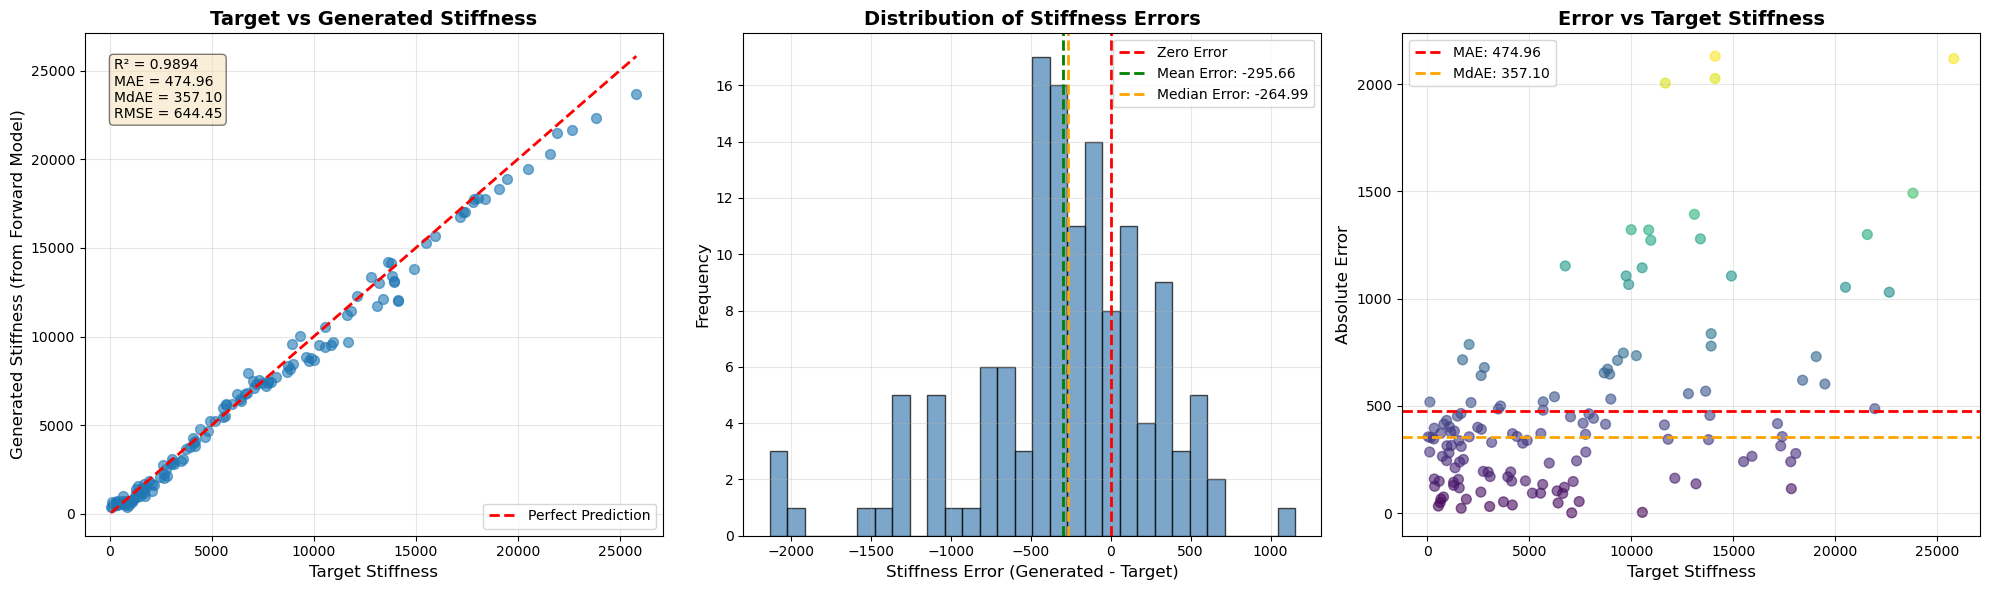

In [48]:
def evaluate(model, forward_model, X_test_scaled, y_test_scaled, scaler_X, scaler_y, device):
    model.eval()
    forward_model.eval()
    
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
        y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)
        
        # Generate designs conditioned on test set stiffness values
        # Sample from latent space
        z = torch.randn(len(X_test_scaled), model.mean_layer.out_features).to(device)
        
        # Decode using test stiffness as condition
        x_hat = model.decode(z, y_test_tensor)
        
        # Convert to numpy for sklearn metrics (denormalize for interpretable metrics)
        X_test_actual = scaler_X.inverse_transform(X_test_scaled)
        X_test_generated = scaler_X.inverse_transform(x_hat.cpu().numpy())
        y_test_actual = scaler_y.inverse_transform(y_test_scaled).flatten()
        
        # Use forward model to predict stiffness from generated designs
        X_generated_tensor = torch.FloatTensor(X_test_generated).to(device)
        y_generated_pred = forward_model(X_generated_tensor).cpu().numpy().flatten()
        
        print("\n" + "="*130)
        print("TEST SET EVALUATION")
        print("="*130)
        print("Task: Given stiffness from test set, generate design parameters")
        print(f"Number of test samples: {len(X_test_scaled)}")
        
        print("\n" + "-"*130)
        print("Sample comparisons (first 5):")
        print(f"{'#':>3} {'Target Stiff':>13} {'Generated Stiff':>15} {'Stiff Error':>13} {'Act Thick':>12} {'Gen Thick':>12} {'Act Height':>12} {'Gen Height':>12} {'Act Angle':>12} {'Gen Angle':>12}")
        print("-"*130)
        for i in range(min(5, len(X_test_actual))):
            stiff_error = abs(y_test_actual[i] - y_generated_pred[i])
            print(f"{i+1:3} {y_test_actual[i]:13.2f} {y_generated_pred[i]:15.2f} {stiff_error:13.2f} "
                  f"{X_test_actual[i,0]:12.4f} {X_test_generated[i,0]:12.4f} "
                  f"{X_test_actual[i,1]:12.4f} {X_test_generated[i,1]:12.4f} "
                  f"{X_test_actual[i,2]:12.4f} {X_test_generated[i,2]:12.4f}")
        
        print("\n" + "-"*130)
        
        # Calculate stiffness prediction metrics
        stiff_mae = mean_absolute_error(y_test_actual, y_generated_pred)
        stiff_mdae = median_absolute_error(y_test_actual, y_generated_pred)
        stiff_mse = mean_squared_error(y_test_actual, y_generated_pred)
        stiff_rmse = np.sqrt(stiff_mse)

        print("\nSTIFFNESS PREDICTION METRICS:")
        print(f"  MAE:   {stiff_mae:.4f}")
        print(f"  MdAE:  {stiff_mdae:.4f}")
        print(f"  MSE:   {stiff_mse:.4f}")
        print(f"  RMSE:  {stiff_rmse:.4f}")
        
        print("\n" + "-"*130)
        
        param_names = ['Thickness', 'Height', 'Angle (deg)']
        overall_metrics = {'mae': [], 'mdae': [], 'mse': [], 'rmse': []}
        
        for i, param_name in enumerate(param_names):
            actual = X_test_actual[:, i]
            generated = X_test_generated[:, i]
            
            mae = mean_absolute_error(actual, generated)
            mdae = median_absolute_error(actual, generated)
            mse = mean_squared_error(actual, generated)
            rmse = np.sqrt(mse)
            
            overall_metrics['mae'].append(mae)
            overall_metrics['mdae'].append(mdae)
            overall_metrics['mse'].append(mse)
            overall_metrics['rmse'].append(rmse)
            
            print(f"\n{param_name}:")
            print(f"  MAE:   {mae:.4f}")
            print(f"  MdAE:  {mdae:.4f}")
            print(f"  MSE:   {mse:.4f}")
            print(f"  RMSE:  {rmse:.4f}")
        
        print("="*130)
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        # 1. Actual vs Generated Stiffness (scatter plot)
        ax1 = axes[0]
        ax1.scatter(y_test_actual, y_generated_pred, alpha=0.6, s=50)
        
        # Perfect prediction line
        min_val = min(y_test_actual.min(), y_generated_pred.min())
        max_val = max(y_test_actual.max(), y_generated_pred.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        ax1.set_xlabel('Target Stiffness', fontsize=12)
        ax1.set_ylabel('Generated Stiffness (from Forward Model)', fontsize=12)
        ax1.set_title('Target vs Generated Stiffness', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        from sklearn.metrics import r2_score
        r2 = r2_score(y_test_actual, y_generated_pred)
        ax1.text(0.05, 0.95, f'R² = {r2:.4f}\nMAE = {stiff_mae:.2f}\nMdAE = {stiff_mdae:.2f}\nRMSE = {stiff_rmse:.2f}',
                transform=ax1.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 2. Stiffness Error Distribution
        ax2 = axes[1]
        errors = y_generated_pred - y_test_actual
        ax2.hist(errors, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
        ax2.axvline(x=np.mean(errors), color='g', linestyle='--', linewidth=2, label=f'Mean Error: {np.mean(errors):.2f}')
        ax2.axvline(x=np.median(errors), color='orange', linestyle='--', linewidth=2, label=f'Median Error: {np.median(errors):.2f}')
        ax2.set_xlabel('Stiffness Error (Generated - Target)', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title('Distribution of Stiffness Errors', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Error vs Target Stiffness
        ax3 = axes[2]
        ax3.scatter(y_test_actual, np.abs(errors), alpha=0.6, s=50, c=np.abs(errors), cmap='viridis')
        ax3.axhline(y=stiff_mae, color='r', linestyle='--', linewidth=2, label=f'MAE: {stiff_mae:.2f}')
        ax3.axhline(y=stiff_mdae, color='orange', linestyle='--', linewidth=2, label=f'MdAE: {stiff_mdae:.2f}')
        ax3.set_xlabel('Target Stiffness', fontsize=12)
        ax3.set_ylabel('Absolute Error', fontsize=12)
        ax3.set_title('Error vs Target Stiffness', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        
        plt.tight_layout()
        plt.show()
        
        overall_metrics['stiffness'] = {
            'mae': stiff_mae,
            'mdae': stiff_mdae,
            'mse': stiff_mse,
            'rmse': stiff_rmse,
            'r2': r2
        }
    
    return overall_metrics

metrics = evaluate(model, forward_model, X_test_scaled, y_test_scaled, scaler_X, scaler_y, device)

In [24]:
def generate(model, stiffness, x, y, samples, device='cpu'):
    model.eval()
    with torch.no_grad():
        normalized_stiffness = scaler_y.transform([[stiffness]])
        stiffness_tensor = torch.FloatTensor(normalized_stiffness).to(device) # Normalize 

        condition = stiffness_tensor.repeat(samples, 1) # Repeat for each sample

        z = torch.randn(samples, model.mean_layer.out_features).to(device)

        generated = model.decode(z, condition)

        generated_np = generated.cpu().numpy()
        designs = scaler_X.inverse_transform(generated_np)
    return designs

Generating 10 designs for target stiffness: 5000

TARGET STIFFNESS: 5000
#     Thickness       Height          Angle (deg)     Predicted       Error          
------------------------------------------------------------------------------------------
1     3.3842          93.7715         62.5375         5262.12         262.12         
2     4.5096          82.1727         59.4699         5399.71         399.71         
3     7.7441          61.0593         47.9044         5122.06         122.06         
4     3.7777          88.5278         61.2053         5092.53         92.53          
5     6.6674          66.4270         55.5172         5360.86         360.86         
6     6.3810          68.3988         56.5038         5756.23         756.23         
7     3.8018          89.2482         61.1666         5247.43         247.43         
8     6.6535          66.3524         54.9531         5347.89         347.89         
9     5.4486          74.0742         58.1530         5374.80 

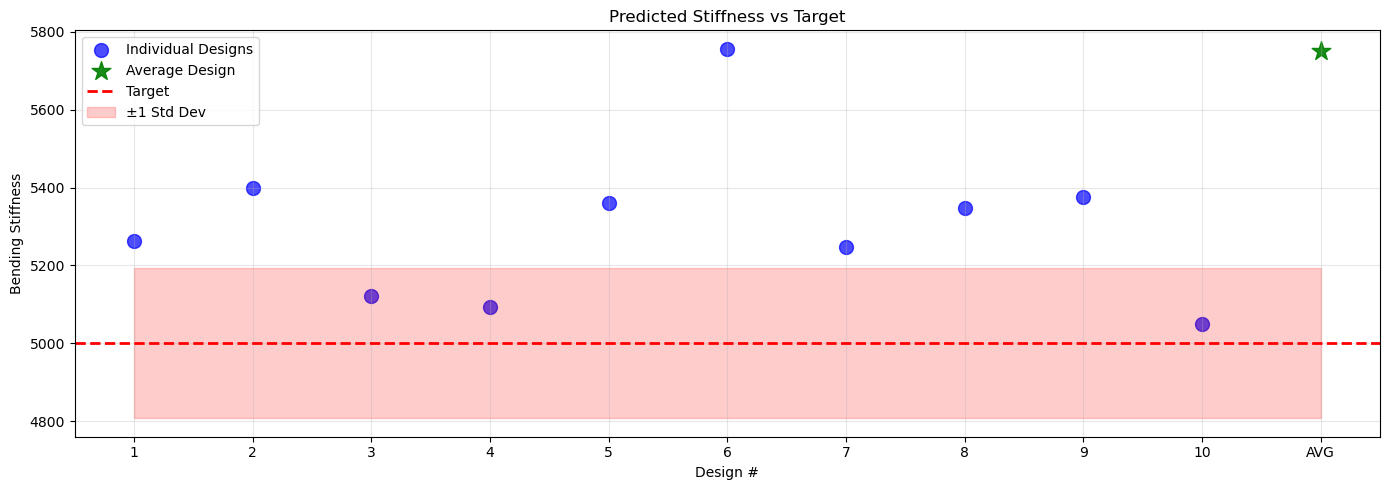


SUMMARY
Target Stiffness:                    5000.00
Mean Predicted (Individual Designs): 5301.42
Average Design Predicted:            5750.29

Mean Error (Individual Designs):     301.42
Average Design Error:                750.29

Improvement using Average:           -448.87


In [27]:
def verify_designs(designs, forward_model, scaler_X, scaler_y, target_stiffness, device='cpu'):
    """Verify individual designs using the forward model"""
    forward_model.eval()
    
    with torch.no_grad():
        # Convert designs to tensor (designs are already denormalized from VAE)
        designs_tensor = torch.FloatTensor(designs).to(device)
        
        # Predict stiffness using forward model (expects denormalized input)
        predicted_stiffness = forward_model(designs_tensor)
        
        # Convert to numpy
        predicted_stiffness = predicted_stiffness.cpu().numpy()
        
    return predicted_stiffness.flatten()

def verify_average_design(designs, forward_model, device='cpu'):
    """Calculate average design and predict its stiffness"""
    forward_model.eval()
    
    # Calculate average design parameters
    avg_thickness = np.mean(designs[:, 0])
    avg_height = np.mean(designs[:, 1])
    avg_angle = np.mean(designs[:, 2])
    
    avg_design = np.array([[avg_thickness, avg_height, avg_angle]])
    
    with torch.no_grad():
        # Convert to tensor
        avg_design_tensor = torch.FloatTensor(avg_design).to(device)
        
        # Predict stiffness for average design
        avg_predicted_stiffness = forward_model(avg_design_tensor)
        avg_predicted_stiffness = avg_predicted_stiffness.cpu().numpy().flatten()[0]
    
    return avg_design, avg_predicted_stiffness

# Generate designs for a target stiffness
test_stiffness = 5000
n_samples = 10

print(f"Generating {n_samples} designs for target stiffness: {test_stiffness}")
designs = generate(model, test_stiffness, scaler_X, scaler_y, samples=n_samples, device=device)

# Verify the designs using forward model
predicted_stiffness = verify_designs(designs, forward_model, scaler_X, scaler_y, 
                                     test_stiffness, device=device)

# Verify the average design
avg_design, avg_predicted_stiffness = verify_average_design(designs, forward_model, device=device)

# Display results
print("\n" + "="*90)
print(f"TARGET STIFFNESS: {test_stiffness}")
print("="*90)
print(f"{'#':<5} {'Thickness':<15} {'Height':<15} {'Angle (deg)':<15} {'Predicted':<15} {'Error':<15}")
print("-"*90)

errors = []
for i, (design, pred_stiff) in enumerate(zip(designs, predicted_stiffness), 1):
    error = abs(pred_stiff - test_stiffness)
    errors.append(error)
    print(f"{i:<5} {design[0]:<15.4f} {design[1]:<15.4f} {design[2]:<15.4f} "
          f"{pred_stiff:<15.2f} {error:<15.2f}")

print("-"*90)
print(f"Mean Absolute Error: {np.mean(errors):.2f}")
print(f"Std Dev of Error: {np.std(errors):.2f}")
print(f"Min Error: {np.min(errors):.2f}")
print(f"Max Error: {np.max(errors):.2f}")

# Display average design
print("\n" + "="*90)
print("AVERAGE DESIGN")
print("="*90)
avg_error = abs(avg_predicted_stiffness - test_stiffness)
print(f"{'Type':<5} {'Thickness':<15} {'Height':<15} {'Angle (deg)':<15} {'Predicted':<15} {'Error':<15}")
print("-"*90)
print(f"{'AVG':<5} {avg_design[0][0]:<15.4f} {avg_design[0][1]:<15.4f} {avg_design[0][2]:<15.4f} "
      f"{avg_predicted_stiffness:<15.2f} {avg_error:<15.2f}")
print("-"*90)

# Compare with actual closest designs from dataset
print("\n" + "="*90)
print("ACTUAL CLOSEST DESIGNS FROM DATASET")
print("="*90)

df['diff'] = (df['Bending_Stiffness'] - test_stiffness).abs()
closest_rows = df.nsmallest(5, 'diff')

print(f"{'#':<5} {'Thickness':<15} {'Height':<15} {'Angle (deg)':<15} {'Stiffness':<15} {'Error':<15}")
print("-"*90)
for i, (idx, row) in enumerate(closest_rows.iterrows(), 1):
    print(f"{i:<5} {row['Thickness']:<15.4f} {row['Height']:<15.4f} "
          f"{row['Angle (deg)']:<15.4f} {row['Bending_Stiffness']:<15.2f} {row['diff']:<15.2f}")

fig, axes = plt.subplots(figsize=(14, 5))
# Predicted vs Target stiffness (including average)
axes.scatter(range(1, n_samples+1), predicted_stiffness, 
            label='Individual Designs', alpha=0.7, s=100, color='blue')
axes.scatter([n_samples+1], [avg_predicted_stiffness], 
            label='Average Design', alpha=0.9, s=200, color='green', marker='*')
axes.axhline(y=test_stiffness, color='r', linestyle='--', linewidth=2, label='Target')
axes.fill_between(range(1, n_samples+2), 
                  test_stiffness - np.std(errors), 
                  test_stiffness + np.std(errors), 
                  alpha=0.2, color='red', label='±1 Std Dev')
axes.set_xlabel('Design #')
axes.set_ylabel('Bending Stiffness')
axes.set_title('Predicted Stiffness vs Target')
axes.legend()
axes.grid(True, alpha=0.3)
axes.set_xticks(range(1, n_samples+2))
axes.set_xticklabels([str(i) for i in range(1, n_samples+1)] + ['AVG'])

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("SUMMARY")
print("="*90)
print(f"Target Stiffness:                    {test_stiffness:.2f}")
print(f"Mean Predicted (Individual Designs): {np.mean(predicted_stiffness):.2f}")
print(f"Average Design Predicted:            {avg_predicted_stiffness:.2f}")
print(f"")
print(f"Mean Error (Individual Designs):     {np.mean(errors):.2f}")
print(f"Average Design Error:                {avg_error:.2f}")
print(f"")
print(f"Improvement using Average:           {np.mean(errors) - avg_error:.2f}")


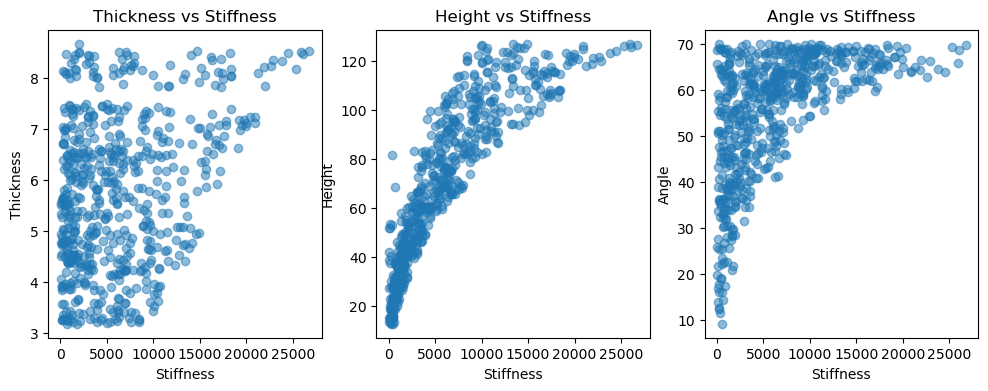

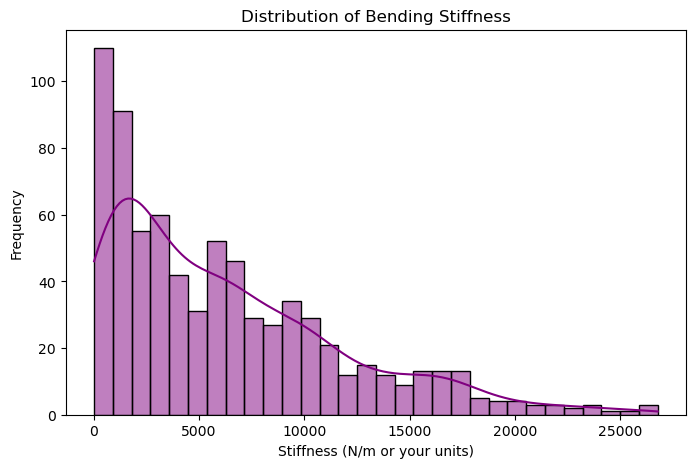

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(y_train, X_train[:, 0], alpha=0.5)
plt.xlabel('Stiffness')
plt.ylabel('Thickness')
plt.title('Thickness vs Stiffness')

plt.subplot(1, 3, 2)
plt.scatter(y_train, X_train[:, 1], alpha=0.5)
plt.xlabel('Stiffness')
plt.ylabel('Height')
plt.title('Height vs Stiffness')

plt.subplot(1, 3, 3)
plt.scatter(y_train, X_train[:, 2], alpha=0.5)
plt.xlabel('Stiffness')
plt.ylabel('Angle')
plt.title('Angle vs Stiffness')

plt.figure(figsize=(8, 5))
sns.histplot(df['Bending_Stiffness'], kde=True, color='purple', bins=30)
plt.title('Distribution of Bending Stiffness')
plt.xlabel('Stiffness (N/m?)')
plt.ylabel('Frequency')
plt.show()

plt.tight_layout()
plt.show()